## Exercise 1: Implement the Logistic Function

In the following, implement the logistic function for binary classification.

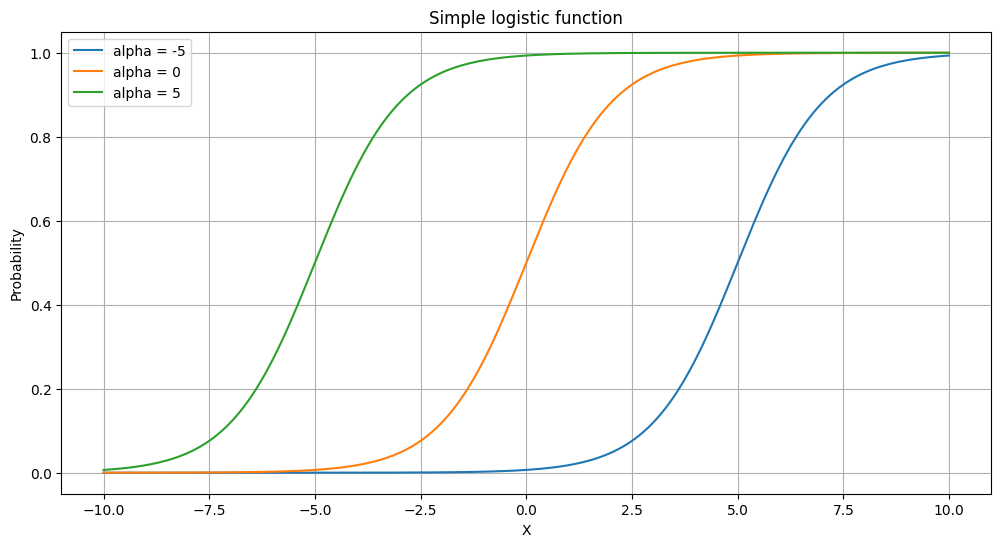

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_function(X, alpha=0):
    return 1 / (1 + np.exp(-(X + alpha)))

# Graph 1: Modifying alpha (intercept term)
x = np.linspace(-10, 10, 200)  # Generate 200 points between -10 and 10
alphas = [-5, 0, 5]  # Different values of alpha to shift the curve

plt.figure(figsize=(12, 6))
for alpha in alphas:
    y = logistic_function(x, alpha=alpha)
    plt.plot(x, y, label=f'alpha = {alpha}')
plt.title('Simple logistic function')
plt.xlabel('X')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


## Exercise 2: Create a Logistic Regression class

Use the logistic function above to derive the probabilities inside the `fit` function

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tolerance = tolerance
        self.coef_ = None
        self.intercept_ = None
        self.classes_ = None

    def fit(self, X, y):
        X, y = check_X_y(X, y, ensure_2d=True)
        n_samples, n_features = X.shape

        self.classes_ = np.unique(y)

        # Initialize parameters
        self.coef_ = np.zeros(n_features)
        self.intercept_ = 0

        for _ in range(self.n_iterations):
            # Make predictions
            y_pred = self._predict_proba(X)

            # Calculate gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Update parameters
            self.coef_ -= self.learning_rate * dw
            self.intercept_ -= self.learning_rate * db

            # Check for convergence
            if np.all(np.abs(self.learning_rate * dw) < self.tolerance):
                break

        return self

    def _predict_proba(self, X):
        linear_pred = np.dot(X, self.coef_) + self.intercept_
        return sigmoid(linear_pred)

    def predict_proba(self, X):
        X = check_array(X, ensure_2d=True)
        return self._predict_proba(X)

    def predict(self, X):
        X = check_array(X, ensure_2d=True)
        return (self._predict_proba(X) >= 0.5).astype(int)

    def _compute_loss(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    





## Exercise 3: Evaluating a classifier

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

# Load the Titanic dataset
url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
titanic = pd.read_csv(url)

# Preprocessing
X = titanic[['Pclass', 'Sex', 'Age', 'Fare']]
y = titanic['Survived']

# Encode 'Sex' column
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})

# Create preprocessing pipeline
numeric_features = ['Age', 'Fare']
numeric_transformer = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Create the full pipeline
pipeline = make_pipeline(preprocessor, LogisticRegression())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

/tmp/ipykernel_3761/812491423.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})


### Step 1

Use the scikit-learn metrics library to manually calculate precision, recall, confusion matrix, and F1 score for our predictions.

In [4]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.6363636363636364
Recall: 0.1044776119402985
F1 Score: 0.1794871794871795
Confusion Matrix:
 [[107   4]
 [ 60   7]]


### Step 2

Use cross_val_score to compute the F1 score using 5-fold cross-validation.

In [5]:
f1_scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')

print("F1 Scores for each fold:", f1_scores)
print("Mean F1 Score:", np.mean(f1_scores))
print("Standard Deviation of F1 Scores:", np.std(f1_scores))

F1 Scores for each fold: [0.14285714 0.45360825 0.29213483 0.28235294 0.26829268]
Mean F1 Score: 0.2878491691687594
Standard Deviation of F1 Scores: 0.0989240024413614


### Step 3

Use cross_validate with a StratifiedKFold sampler to compute multiple metrics (accuracy, precision, recall, and F1 score) using 5-fold cross-validation.

In [7]:
from sklearn.linear_model import LogisticRegression
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

cv_results = cross_validate(pipeline, X, y, cv=skf, scoring=scoring)

for metric in scoring.keys():
    print(f"{metric.capitalize()} Scores for each fold: {cv_results['test_' + metric]}")
    print(f"Mean {metric.capitalize()} Score: {np.mean(cv_results['test_' + metric])}")
    print(f"Standard Deviation of {metric.capitalize()} Scores: {np.std(cv_results['test_' + metric])}\n")


Accuracy Scores for each fold: [0.66292135 0.65168539 0.68926554 0.62146893 0.64971751]
Mean Accuracy Score: 0.6550117437948327
Standard Deviation of Accuracy Scores: 0.021909350687802503

Precision Scores for each fold: [0.68       0.66666667 0.72413793 0.52       0.65      ]
Mean Precision Score: 0.6481609195402298
Standard Deviation of Precision Scores: 0.06864007504536102

Recall Scores for each fold: [0.24637681 0.20289855 0.30882353 0.19117647 0.19117647]
Mean Recall Score: 0.22809036658141518
Standard Deviation of Recall Scores: 0.045193222219155456

F1 Scores for each fold: [0.36170213 0.31111111 0.43298969 0.27956989 0.29545455]
Mean F1 Score: 0.3361654734839997
Standard Deviation of F1 Scores: 0.05570495539008566



### BONUS

If you finish early, try creating learning curves to visualize how the model's performance changes with increasing amounts of training data.

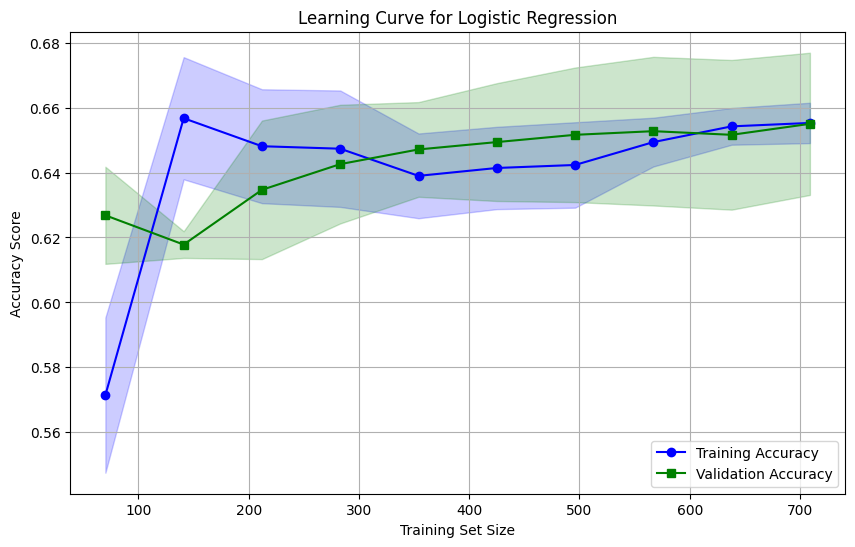

In [8]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, X, y, cv=skf, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes, valid_mean, label='Validation Accuracy', color='green', marker='s')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.2, color='green')

plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid()
plt.show()

## Exercise 4: Implement Softmax

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(z):
    z_exp = np.exp(z - np.max(z, axis=1, keepdims=True))
    return z_exp / np.sum(z_exp, axis=1, keepdims=True)
   

# Example of how softmax works
example_z = np.array([[1.0, 2.0, 0.5], [-1.0, 0.0, 3.0]])
example_softmax = softmax(example_z)
print("\nSoftmax example:")
print("Input:")
print(example_z)
print("Softmax output:")
print(example_softmax)
print("Sum of probabilities for each row:")
print(np.sum(example_softmax, axis=1))


Softmax example:
Input:
[[ 1.   2.   0.5]
 [-1.   0.   3. ]]
Softmax output:
[[0.2312239  0.62853172 0.14024438]
 [0.01714783 0.04661262 0.93623955]]
Sum of probabilities for each row:
[1. 1.]


## Exercise 5: Implement Multiple Logistic Regression

In [10]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array
from sklearn.preprocessing import LabelEncoder

class LogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.01, n_iterations=1000, tolerance=1e-6):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tolerance = tolerance
        self.coef_ = None
        self.intercept_ = None
        self.classes_ = None
        self.n_classes_ = None
        self.label_encoder = None

    def fit(self, X, y):
        X, y = check_X_y(X, y, ensure_2d=True)
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        self.n_classes_ = len(self.classes_)

        n_samples, n_features = X.shape

        # Initialize parameters
        self.coef_ = np.zeros((self.n_classes_, n_features))
        self.intercept_ = np.zeros(self.n_classes_)

        # Convert y to one-hot encoding
        y_onehot = np.eye(self.n_classes_)[y_encoded]


        # What goes here?
        for _ in range(self.n_iterations):
            # Make predictions
            y_pred = self._predict_proba(X)

            # Calculate gradients
            error = y_pred - y_onehot
            grad_w = (1 / n_samples) * np.dot(error.T, X) 
            grad_b = (1 / n_samples) * np.sum(error, axis=0)

            # Update parameters
            self.coef_ -= self.learning_rate * grad_w
            self.intercept_ -= self.learning_rate * grad_b

            # Check for convergence
            if np.linalg.norm(grad_w) < self.tolerance and np.linalg.norm(grad_b) < self.tolerance:
                print(f"Converged at iteration {_}")
                break

        return self

    def _predict_proba(self, X):
        logits = np.dot(X, self.coef_.T) + self.intercept_
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def predict_proba(self, X):
        X = check_array(X, ensure_2d=True)
        return self._predict_proba(X)

    def predict(self, X):
        X = check_array(X, ensure_2d=True)
        y_pred = np.argmax(self._predict_proba(X), axis=1)
        return self.label_encoder.inverse_transform(y_pred)
